# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels
from lib.shared.segment_cellpose import estimate_diameters, segment_cellpose
from lib.shared.segment_microsam import segment_microsam
from lib.shared.segment_stardist import segment_stardist
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.phenotype.extract_phenotype_cp_multichannel import (
    extract_phenotype_cp_multichannel,
)

2025-03-12 14:45:20.242189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.

In [3]:
# parameters for testing
TEST_PLATE = 1
TEST_WELL = "A2"
TEST_TILE = 0
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ["DAPI"]
CHANNEL_CMAPS = ["pure_blue"]

# parameters for feature extraction
FOCI_CHANNEL = None

Loading test image...
Applying illumination correction...
Example corrected image:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


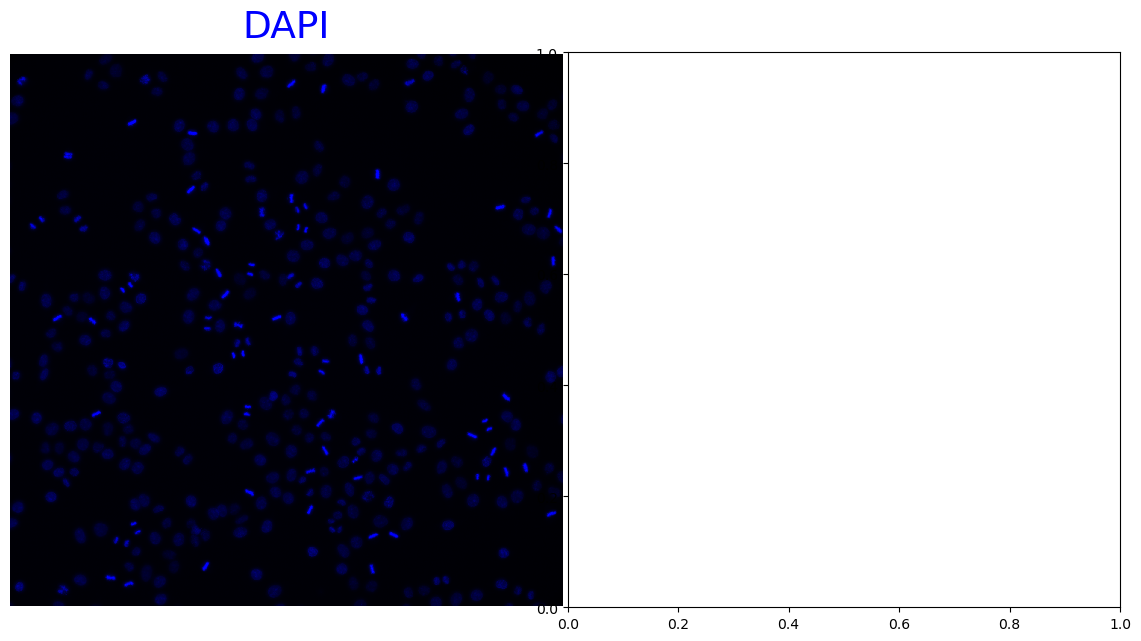

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
# ic_field_path = str(
#     PREPROCESS_FP
#     / "ic_fields"
#     / "phenotype"
#     / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
# )
# ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
# corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)
corrected_image = phenotype_test_image

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Aligning (optional)

- `ALIGN`: Whether to conduct alignment. This is suggested **unless** each image is captured with each channel consecutively. 
- `TARGET`: Index of the channel that other channels will be aligned to.
- `SOURCE`: Index of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.

In [5]:
# Set alignment parameters
ALIGN = False
TARGET = None
SOURCE = None
RIDERS = None
REMOVE_CHANNEL = None

# Derive alignment indexes
if ALIGN:
    TARGET_INDEX = CHANNEL_NAMES.index(TARGET)
    SOURCE_INDEX = CHANNEL_NAMES.index(SOURCE)
    RIDER_INDEXES = [CHANNEL_NAMES.index(r) for r in RIDERS]

In [6]:
if ALIGN:
    print("Aligning channels...")
    aligned_image = align_phenotype_channels(
        corrected_image,
        target=TARGET_INDEX,
        source=SOURCE_INDEX,
        riders=RIDER_INDEXES,
        remove_channel=REMOVE_CHANNEL,
    )
else:
    aligned_image = corrected_image

In [7]:
aligned_image.shape

(1, 2400, 2400)

## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Common Parameters
- `CYTO_CHANNEL`: Channel to use for cell detection (typically "PHALLOIDIN")
- `GPU`: Set to True to use GPU acceleration (if available)
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing)

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".
- `POINTS_PER_SIDE`: Number of points to sample along each side of the image. Default is 32.
- `POINTS_PER_BATCH`: Number of points to process in one batch. Default is 16.
- `STABILITY_SCORE_THRESH`: Threshold for stability score. Default is 0.95.
- `PRED_IOU_THRESH`: Threshold for predicted IoU. Default is 0.88.

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `PROB_THRESH`: Probability threshold for segmentation. Default is 0.479071.
- `NMS_THRESH`: Non-maximum suppression threshold. Default is 0.3.

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [8]:
from cellpose.models import Cellpose
from skimage.util import img_as_ubyte


def prepare_cellpose_dapi(data, dapi_index):
    """Prepare a three-channel RGB image for use with the Cellpose GUI.

    Args:
        data (list or numpy.ndarray): List or array containing DAPI and cytoplasmic channel images.
        dapi_index (int): Index of the DAPI channel in the data.
        cyto_index (int): Index of the cytoplasmic channel in the data.
        logscale (bool, optional): Whether to apply log scaling to the cytoplasmic channel. Default is True.
        log_kwargs (dict, optional): Additional keyword arguments for log scaling.

    Returns:
        numpy.ndarray: Three-channel RGB image prepared for use with Cellpose GUI.
    """
    # Extract DAPI and cytoplasmic channel images from the data
    dapi = data[dapi_index]

    # Create a blank array with the same shape as the DAPI channel
    blank = np.zeros_like(dapi)

    # Normalize the intensity of the DAPI channel and scale it to the range [0, 1]
    dapi_upper = np.percentile(dapi, 99.5)
    dapi = dapi / dapi_upper
    dapi[dapi > 1] = 1

    # Convert the channels to uint8 format for RGB image creation
    red, green, blue = img_as_ubyte(blank), img_as_ubyte(blank), img_as_ubyte(dapi)

    # Stack the channels to create the RGB image and transpose the dimensions
    # return np.array([red, green, blue]).transpose([1, 2, 0])
    return np.array([red, green, blue])


def image_log_scale(data, bottom_percentile=10, floor_threshold=50, ignore_zero=True):
    """Apply log scaling to an image.

    Args:
        data (numpy.ndarray): Input image data.
        bottom_percentile (int, optional): Percentile value for determining the bottom threshold. Default is 10.
        floor_threshold (int, optional): Floor threshold for cutting out noisy bits. Default is 50.
        ignore_zero (bool, optional): Whether to ignore zero values in the data. Default is True.

    Returns:
        numpy.ndarray: Scaled image data after log scaling.
    """
    import numpy as np

    # Convert input data to float
    data = data.astype(float)

    # Select data based on whether to ignore zero values or not
    if ignore_zero:
        data_perc = data[data > 0]
    else:
        data_perc = data

    # Determine the bottom percentile value
    bottom = np.percentile(data_perc, bottom_percentile)

    # Set values below the bottom percentile to the bottom value
    data[data < bottom] = bottom

    # Apply log scaling with floor threshold
    scaled = np.log10(data - bottom + 1)

    # Cut out noisy bits based on the floor threshold
    floor = np.log10(floor_threshold)
    scaled[scaled < floor] = floor

    # Subtract the floor value
    return scaled - floor

In [9]:
# Common parameters
GPU = False
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")

rgb = prepare_cellpose_dapi(aligned_image, DAPI_INDEX)

print("Estimating nuclei diameters...")
model_nuclei = Cellpose(model_type="nuclei", gpu=GPU)
diam_nuclear, _ = model_nuclei.sz.eval(rgb, channels=[3, 0])
diam_nuclear = np.maximum(5.0, diam_nuclear)
diam_nuclear = float(diam_nuclear)
print(f"Estimated nuclear diameter: {diam_nuclear:.1f} pixels")

NUCLEI_DIAMETER = diam_nuclear

dtype.py (576): Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> loading model /home/rkern/.cellpose/models/nucleitorch_0


Estimating nuclei diameters...


INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)


Estimated nuclear diameter: 46.2 pixels


INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> loading model /home/rkern/.cellpose/models/nucleitorch_0


Segmenting image with CellPose...


INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [3, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 37.55 sec


Example microplots for DAPI channel and nuclei segmentation:


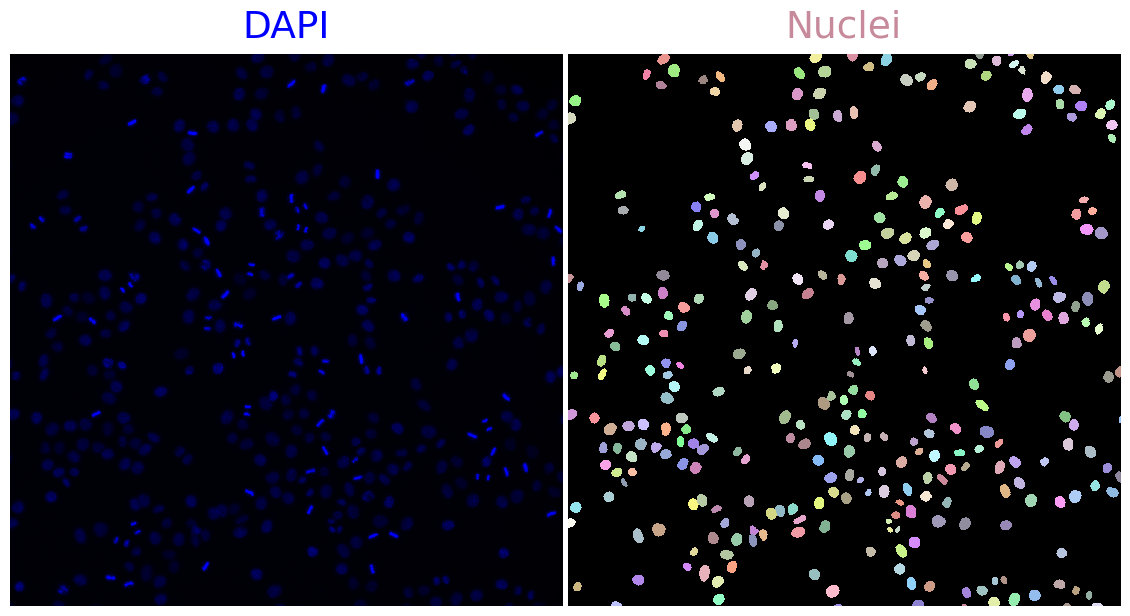

In [10]:
print(f"Segmenting image with CellPose...")

# CREATE NUCLEI ONLY SEGMENTATION!
model_dapi = Cellpose(model_type="nuclei", gpu=GPU)
nuclei, _, _, _ = model_dapi.eval(
    rgb,
    channels=[3, 0],
    diameter=NUCLEI_DIAMETER,
)

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

In [ ]:


def extract_phenotype_cp_multichannel(
    data_phenotype,
    nuclei,
    cells,
    wildcards,
    cytoplasms=None,
    nucleus_channels="all",
    cell_channels="all",
    cytoplasm_channels="all",
    foci_channel=None,
    channel_names=["dapi", "tubulin", "gh2ax", "phalloidin"],
):
    """Extract phenotype features from CellProfiler-like data with multi-channel functionality.

    Args:
        data_phenotype (numpy.ndarray): Phenotype data array of shape (..., CHANNELS, I, J).
        nuclei (numpy.ndarray): Nuclei segmentation data.
        cells (numpy.ndarray): Cell segmentation data.
        cytoplasms (numpy.ndarray, optional): Cytoplasmic segmentation data.
        wildcards (dict): Dictionary containing wildcards.
        nucleus_channels (str or list): List of nucleus channel indices to consider or 'all'.
        cytoplasm_channels (str or list): List of cytoplasm channel indices to consider or 'all'.
        cell_channels (str or list): List of cell channel indices to consider or 'all'.
        foci_channel (int): Index of the channel containing foci information.
        channel_names (list): List of channel names.

    Returns:
        pandas.DataFrame: DataFrame containing extracted phenotype features.
    """
    # If nuclei or cells are empty, return an empty DataFrame
    if np.sum(nuclei) == 0 or np.sum(cells) == 0:
        return pd.DataFrame(columns=["well", "tile"])

    # Check if all channels should be used
    if nucleus_channels == "all":
        try:
            nucleus_channels = list(range(data_phenotype.shape[-3]))
        except:
            nucleus_channels = [0]

    if cell_channels == "all":
        try:
            cell_channels = list(range(data_phenotype.shape[-3]))
        except:
            cell_channels = [0]

    if cytoplasm_channels == "all":
        try:
            cytoplasm_channels = list(range(data_phenotype.shape[-3]))
        except:
            cytoplasm_channels = [0]

    dfs = []

    # Define features
    features = grayscale_features_multichannel
    features.update(correlation_features_multichannel)
    features.update(shape_features)

    # Define function to create column map
    def make_column_map(channels):
        columns = {}
        # Create columns for grayscale features
        for feat, out in grayscale_columns_multichannel.items():
            columns.update(
                {
                    f"{feat}_{n}": f"{channel_names[ch]}_{renamed}"
                    for n, (renamed, ch) in enumerate(product(out, channels))
                }
            )
        # Create columns for correlation features
        for feat, out in correlation_columns_multichannel.items():
            if feat == "lstsq_slope":
                iterator = permutations
            else:
                iterator = combinations
            columns.update(
                {
                    f"{feat}_{n}": renamed.format(
                        first=channel_names[first], second=channel_names[second]
                    )
                    for n, (renamed, (first, second)) in enumerate(
                        product(out, iterator(channels, 2))
                    )
                }
            )
        # Add shape columns
        columns.update(shape_columns)
        return columns

    # Create column maps for nucleus and cell
    nucleus_columns = make_column_map(nucleus_channels)
    cell_columns = make_column_map(cell_channels)

    # Extract nucleus features
    dfs.append(
        extract_features(
            data_phenotype[..., nucleus_channels, :, :],
            nuclei,
            wildcards,
            features,
            multichannel=True,
        )
        .rename(columns=nucleus_columns)
        .set_index("label")
        .rename(columns=lambda x: "nucleus_" + x if x not in wildcards.keys() else x)
    )

    # Extract cell features
    dfs.append(
        extract_features(
            data_phenotype[..., cell_channels, :, :],
            cells,
            dict(),
            features,
            multichannel=True,
        )
        .rename(columns=cell_columns)
        .set_index("label")
        .add_prefix("cell_")
    )

    # Extract cytoplasmic features if cytoplasms are provided
    if cytoplasms is not None:
        cytoplasmic_columns = make_column_map(cytoplasm_channels)
        dfs.append(
            extract_features(
                data_phenotype[..., cytoplasm_channels, :, :],
                cytoplasms,
                dict(),
                features,
                multichannel=True,
            )
            .rename(columns=cytoplasmic_columns)
            .set_index("label")
            .add_prefix("cytoplasm_")
        )

    # Extract foci features if foci channel is provided
    if foci_channel is not None:
        foci = find_foci(
            data_phenotype[..., foci_channel, :, :], remove_border_foci=True
        )
        dfs.append(
            extract_features_bare(foci, cells, features=lib.shared.features.foci)
            .set_index("label")
            .add_prefix(f"cell_{channel_names[foci_channel]}_")
        )

    # Extract nucleus and cell neighbors
    dfs.append(
        neighbor_measurements(nuclei, distances=[1])
        .set_index("label")
        .add_prefix("nucleus_")
    )

    dfs.append(
        neighbor_measurements(cells, distances=[1])
        .set_index("label")
        .add_prefix("cell_")
    )
    if cytoplasms is not None:
        dfs.append(
            neighbor_measurements(cytoplasms, distances=[1])
            .set_index("label")
            .add_prefix("cytoplasm_")
        )

    # Concatenate data frames and reset index
    return pd.concat(dfs, axis=1, join="outer", sort=True).reset_index()

In [ ]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(
    aligned_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)

phenotype_cp

In [ ]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

## Add phenotype process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_phenotype_paramsearch` will systematically explore combinations of:

1. Size Parameters:
   - `nuclei_diameter`: Expected diameter of cell nuclei
   - `cell_diameter`: Expected diameter of cell cytoplasm
   
2. CellPose Parameters:
   - `flow_threshold`: Controls sensitivity of segmentation boundaries (default value 0.4)
     - Lower values: More aggressive segmentation, may over-segment
     - Higher values: More conservative, may miss cell boundaries
   - `cellprob_threshold`: Controls cell detection confidence (default value 0)
     - Lower values: Detects more potential cells, may include false positives
     - Higher values: More stringent detection, may miss weaker signals

The parameter search will:
1. Generate segmentations using different parameter combinations
2. Save results for each combination
3. Allow you to visually inspect results to choose optimal values
4. Help identify the best balance between over- and under-segmentation

Running these parameter searches is a time and resource intensive process and should only be done on a small subset of the tiles in the dataset.

In [ ]:
# Add phenotype section
config["phenotype"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "align": ALIGN,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "method": SEGMENTATION_METHOD,
    "reconcile": RECONCILE,
    "gpu": GPU,
    "mode": None,
}

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["phenotype"].update(
        {
            "nuclei_diameter": NUCLEI_DIAMETER,
            "cell_diameter": CELL_DIAMETER,
            "flow_threshold": FLOW_THRESHOLD,
            "cellprob_threshold": CELLPROB_THRESHOLD,
            "cyto_model": CELLPOSE_MODEL,
        }
    )
elif SEGMENTATION_METHOD == "microsam":
    config["phenotype"].update(
        {
            "microsam_model": MICROSAM_MODEL,
            "points_per_side": POINTS_PER_SIDE,
            "points_per_batch": POINTS_PER_BATCH,
            "stability_score_thresh": STABILITY_SCORE_THRESH,
            "pred_iou_thresh": PRED_IOU_THRESH,
        }
    )
elif SEGMENTATION_METHOD == "stardist":
    config["phenotype"].update(
        {
            "stardist_model": STARDIST_MODEL,
            "prob_thresh": PROB_THRESH,
            "nms_thresh": NMS_THRESH,
        }
    )

if ALIGN:  # then add the source index, rider indexes, and remove index
    config["phenotype"]["target"] = TARGET_INDEX
    config["phenotype"]["source"] = SOURCE_INDEX
    config["phenotype"]["riders"] = RIDER_INDEXES
    config["phenotype"]["remove_channel"] = REMOVE_CHANNEL

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)